## BioFaceNet

Author - Parth Agrawal

In [213]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [214]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader

import tqdm
import matplotlib.pyplot as plt 
from PIL import Image
import numpy as np
import os 
import zipfile 
import gdown

In [215]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


### Download Dataset

In [216]:
data_root = 'Data/celeba'

dataset_folder = f'{data_root}/img_align_celeba'

url = 'https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH'


download_path = f'{data_root}/img_celeba'


if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(dataset_folder)

gdown.download(url, download_path, quiet=False)

## Use TQDM
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(dataset_folder)

Downloading...
From: https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH
To: /content/Data/celeba/img_celeba
1.44GB [00:17, 83.4MB/s]


## Create Dataset

In [217]:
def load_images(path,limit = 128):
  files = os.listdir(path)
  images_arr = []
  n = len(files)
  i = 0 
  while(i < limit):
    images_arr.append(plt.imread(path + '/' + files[i]) / 255)
    i += 1
  return np.array(images_arr)

In [218]:
PATH = "/content/Data/celeba/img_align_celeba/img_align_celeba"
data = load_images(PATH)

Size of the Dataset : (128, 218, 178, 3)


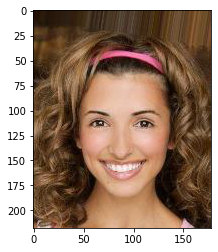

In [219]:
print(f'Size of the Dataset : {data.shape}')
plt.imshow(data[0])

## Dataloader

In [220]:
# Change the validation Dataset
data_tensor = torch.tensor(data).float().to(device)
batch_size = 4
dataloaders = {
    'train': DataLoader(data_tensor, batch_size=batch_size, shuffle=False),
    'val': DataLoader(data_tensor, batch_size=batch_size, shuffle=False)
}

## Model

### Scaling

In [327]:
def scaling(lighting,b,fmel,fblood,shading,specmask,b_size):

  softmax = nn.Softmax(dim = 1)
  sigmoid = nn.Sigmoid()

  lighting_weight = softmax(lighting[:,:-1])
  weightA = lighting_weight[:,0]
  weightD = lighting_weight[:,1]
  Fweights = lighting_weight[:,2:]
  CCT = lighting[:,14]
  CCT = ((22 - 1) / (1 + torch.exp(-CCT))) + 1

  b = 6 * sigmoid(b) - 3
  b = b/3

  fmel = (sigmoid(fmel)*2) - 1
  fblood = (sigmoid(fblood)*2) - 1
  shading = torch.exp(shading)
  specmask = torch.exp(specmask)

  return weightA,weightD,CCT,Fweights,b,fmel,fblood,shading,specmask

### Illumination Model

In [328]:
illumA = torch.tensor(np.load('illumA.npy'))
illumDmeasured = torch.tensor(np.load('illumDmeasured.npy'))
illF = torch.tensor(np.load('illF.npy'))
illumA = illumA / torch.sum(illumA,dim = 2)
illF = illF / torch.sum(illF,dim=2,keepdims = True)
illumDmeasured = illumDmeasured / torch.sum(illumDmeasured,dim = 1,keepdims = True)

illumA = illumA.view(1,1,1,33)
illumA = torch.cat([illumA] * batch_size,dim = 0)

illumDmeasured = illumDmeasured.view(1,1,22,33)
illumDmeasured = illumDmeasured.permute(0,1,3,2)
illumDmeasured = torch.cat([illumDmeasured] * batch_size,dim = 0)

illF = illF.view(1,1,33,12)
illF = torch.cat([illF] * batch_size,dim = 0)

In [329]:
def illuminationModel(weightA,weightD,Fweights,CCT,illumA,illumDNorm,illumFNorm):

  weightA = weightA.view(weightA.shape[0],1,1,1)
  weightD = weightD.view(weightD.shape[0],1,1,1)
  Fweights = Fweights.view(Fweights.shape[0],1,1,12)
  CCT = CCT.view(CCT.shape[0],1,1,1)

  illumA = illumA * weightA
  illD = illumDNorm / CCT
  illD = torch.sum(illD,dim = 3, keepdims = True)
  
  illD = illD * weightD
  illF = torch.sum(illumFNorm*Fweights,dim = 3,keepdims = True)

  illumA = illumA.view(illumA.shape[0],1,33,1)
  e = (illumA + illD + illF)
  e = e /torch.sum(e,dim=2,keepdims = True)
  e = e.permute(0,2,1,3)
  return e 

## Camera Model

In [330]:
from sklearn.decomposition import PCA
rgbCMF = np.load('rgbCMF.npy')
rgbCMF.shape
wavelength = 33

In [331]:
 def CameraSensitivityPCA(cmf):
  X = np.zeros((99,28))
  Y = np.zeros((99,28))
  redS = cmf[0]
  greenS = cmf[1]
  blueS = cmf[2]

  Y[:33,:] = redS/np.sum(redS,axis = 1,keepdims=True)
  Y[33:66,:] = greenS/np.sum(greenS,axis = 1,keepdims=True)
  Y[66:,:] = blueS/np.sum(blueS,axis = 1,keepdims=True)

  pca = PCA(n_components = 2)
  out = pca.fit(Y.T)
  return out.components_,out.mean_


In [332]:
def camera_model(mu,PC,b,wavelength):
  relu = torch.nn.ReLU()
  S = b @ PC + mu
  S = relu(S)
  Sr = S[:,:wavelength]
  Sg = S[:,wavelength:2* wavelength]
  Sb = S[:,2*wavelength:]
  Sr = Sr.view(Sr.shape[0],Sr.shape[1],1,1)
  Sg = Sg.view(Sg.shape[0],Sg.shape[1],1,1)
  Sb = Sb.view(Sb.shape[0],Sb.shape[1],1,1)
  return Sr,Sg,Sb

### Compute Lightcolor

In [333]:
def computelightcolor(e,Sr,Sg,Sb):
  s1 = torch.sum(Sr * e,dim = 1,keepdims = True)
  s2 = torch.sum(Sg * e,dim = 1,keepdims = True)
  s3 = torch.sum(Sb * e,dim = 1,keepdims = True)
  lightcolor = torch.cat((s1,s2,s3),dim = 1)
  return lightcolor

### Compute Specularities

In [334]:
def specularities(specmask,lightcolor):
  spec = specmask * lightcolor
  spec = torch.sum(spec,dim=1,keepdims = True)
  return spec

### BiotoSpectralRef

In [335]:
Newskincolour = torch.tensor(np.load('Newskincolour.npy'))
Newskincolour = Newskincolour.view(1,Newskincolour.shape[0],Newskincolour.shape[1],Newskincolour.shape[2])
Newskincolour = Newskincolour.permute(0,3,1,2)
Newskincolour = torch.cat(batch_size*[Newskincolour],0)
print(Newskincolour.shape)
print(fmel.shape)
print(fblood.shape)

torch.Size([4, 33, 256, 256])
torch.Size([4, 218, 178])
torch.Size([4, 218, 178])


In [336]:
def biotoSpecref(fmel,fblood,Newskincolor):
  fmel = fmel.view((fmel.shape[0],fmel.shape[1],fmel.shape[2],1))
  fblood = fblood.view((fblood.shape[0],fblood.shape[1],fblood.shape[2],1))
  grid = torch.cat((fmel,fblood),3)
  R_total = torch.nn.functional.grid_sample(Newskincolor,grid, mode='bilinear')
  return R_total

### Image Formation

In [337]:
def ImageFormation(R_total,Sr,Sg,Sb,e,specular,shading):

  shading = shading.view(shading.shape[0],1,shading.shape[1],shading.shape[2])

  spectraRef = R_total * e
  rChannel = torch.sum(spectraRef * Sr,axis = 1,keepdims= True)
  gChannel = torch.sum(spectraRef * Sg,axis = 1,keepdims = True)
  bChannel = torch.sum(spectraRef * Sb,axis = 1,keepdims = True)

  diffuseAldebo = torch.cat((rChannel,gChannel,bChannel), axis = 1)
  ShadedDiffuse = diffuseAldebo * shading
  rawApperance = ShadedDiffuse + specular

  return rawApperance, diffuseAldebo

### White Balance

In [338]:
def white_balance(rawAppearance,lightcolor):
  wbalanced = rawAppearance / lightcolor
  return wbalanced

### T Matrix

In [339]:
def T_matrix(Tmatrix,b):
  b_grid = b.view(b.shape[0],1,1,b.shape[1])
  Tmatrix = Tmatrix.permute(0,3,1,2)
  T_RAW2XYZ = torch.nn.functional.grid_sample(Tmatrix,b_grid, mode='bilinear')
  return T_RAW2XYZ

### Raw to RGB

In [340]:
def rawtorgb(wb,T_raw2xyz):
  Ix = wb[:,0,:,:] * T_raw2xyz[:,0] + wb[:,1,:,:] * T_raw2xyz[:,3] + wb[:,2,:,:] * T_raw2xyz[:,6]
  Iy = wb[:,0,:,:] * T_raw2xyz[:,1] + wb[:,1,:,:] * T_raw2xyz[:,4] + wb[:,2,:,:] * T_raw2xyz[:,7]
  Iz = wb[:,0,:,:] * T_raw2xyz[:,2] + wb[:,1,:,:] * T_raw2xyz[:,5] + wb[:,2,:,:] * T_raw2xyz[:,8]

  print(Ix.shape)
  print(Iy.shape)
  print(Iz.shape)

  Ix = Ix.view((-1,1,Ix.shape[1],Ix.shape[2]))
  Iy = Iy.view((-1,1,Iy.shape[1],Iy.shape[2]))
  Iz = Iz.view((-1,1,Iz.shape[1],Iz.shape[2]))

  print(Ix.shape)
  print(Iy.shape)
  print(Iz.shape)

  Ixyz = torch.cat((Ix,Iy,Iz),dim = 1)
  Txyzrgb = torch.tensor([3.2406, -1.5372, -0.4986,-0.9689, 1.8758, 0.0415,0.0557, -0.2040, 1.057])

  R = Txyzrgb[0] * Ixyz[:,0,:,:] + Txyzrgb[3] * Ixyz[:,1,:,:] + Txyzrgb[6] * Ixyz[:,2,:,:]
  G = Txyzrgb[1] * Ixyz[:,0,:,:] + Txyzrgb[4] * Ixyz[:,1,:,:] + Txyzrgb[7] * Ixyz[:,2,:,:]
  B = Txyzrgb[2] * Ixyz[:,0,:,:] + Txyzrgb[5] * Ixyz[:,1,:,:] + Txyzrgb[8] * Ixyz[:,2,:,:]
  
  print(R.shape)
  print(G.shape)
  print(B.shape)

  R = R.view((-1,1,R.shape[1],R.shape[2]))
  G = G.view((-1,1,G.shape[1],G.shape[2]))
  B = B.view((-1,1,B.shape[1],B.shape[2]))


  sRGBim = torch.cat((R,G,B),dim = 1)

  relu = nn.ReLU()
  sRGBim = relu(sRGBim)
  return sRGBim

### Encoder Architecture

In [341]:
class encoder(nn.Module):
  def __init__(self,in_channels):
    super(encoder,self).__init__()

    self.conv1_down = nn.Conv2d(in_channels,32,(3,3),stride = 1,padding = 1)
    self.batchnorm1_down = torch.nn.BatchNorm2d(32)
    self.conv2_down = nn.Conv2d(32,64,(3,3),stride = 1,padding = 1)
    self.batchnorm2_down = torch.nn.BatchNorm2d(64)
    self.conv3_down = nn.Conv2d(64,128,(3,3),stride = 1,padding = 1)
    self.batchnorm3_down = torch.nn.BatchNorm2d(128)
    self.conv4_down = nn.Conv2d(128,256,(3,3),stride = 1,padding = 1)
    self.batchnorm4_down = torch.nn.BatchNorm2d(256)
    self.conv5_down = nn.Conv2d(256,512,(3,3),stride = 1,padding = 1)
    self.batchnorm5_down = torch.nn.BatchNorm2d(512)
    self.relu = nn.ReLU()
    self.max_pool = nn.MaxPool2d((2,2),stride = 2)
    self.skip_connections = []
    

  def forward(self,x):
    x = x.permute(0,3,1,2)
    x = self.conv1_down(x)
    x = self.batchnorm1_down(x)
    x = self.relu(x)
    self.skip_connections.append(x)
    x = self.max_pool(x)
    x = self.conv2_down(x)
    x = self.batchnorm2_down(x)
    x = self.relu(x)
    self.skip_connections.append(x)
    x = self.max_pool(x)
    x = self.conv3_down(x)
    x = self.batchnorm3_down(x)
    x = self.relu(x)
    self.skip_connections.append(x)
    x = self.max_pool(x)
    x = self.conv4_down(x)
    x = self.batchnorm4_down(x)
    x = self.relu(x)
    self.skip_connections.append(x)
    x = self.max_pool(x)
    x = self.conv5_down(x)
    x = self.batchnorm5_down(x)
    x = self.relu(x)


    return [x,self.skip_connections]


In [342]:
class decoder(nn.Module):
  def __init__(self):
    super(decoder,self).__init__()
    self.upsample_1 = torch.nn.Upsample(size=(27,22))
    self.conv1_up = nn.Conv2d(768,256,(3,3),stride = 1,padding = 1)
    self.batchnorm1_up = torch.nn.BatchNorm2d(256)

    self.upsample_2 = torch.nn.Upsample(size=(54,44))
    self.conv2_up = nn.Conv2d(384,128,(3,3),stride = 1,padding = 1)
    self.batchnorm2_up = torch.nn.BatchNorm2d(128)

    self.upsample_3 = torch.nn.Upsample(size=(109,89))
    self.conv3_up = nn.Conv2d(192,64,(3,3),stride = 1,padding = 1)
    self.batchnorm3_up = torch.nn.BatchNorm2d(64)
    
    self.upsample_4 = torch.nn.Upsample(size=(218,178))
    self.conv4_up = nn.Conv2d(96,32,(3,3),stride = 1,padding = 1)
    self.batchnorm4_up = torch.nn.BatchNorm2d(32)
    
    self.conv5_up = nn.Conv2d(32,1,(3,3),stride = 1,padding = 1)
    self.relu = nn.ReLU()
  
  def forward(self,latent,skip_connections):

    self.skip_connections = skip_connections
    x = self.upsample_1(latent)
    x = torch.cat((x,self.skip_connections[-1]),1)
    x = self.conv1_up(x)
    x = self.batchnorm1_up(x)
    x = self.relu(x)

    x = self.upsample_2(x)
    x = torch.cat((x,self.skip_connections[-2]),1)
    x = self.conv2_up(x)
    x = self.batchnorm2_up(x)
    x = self.relu(x)

    x = self.upsample_3(x)
    x = torch.cat((x,self.skip_connections[-3]),1)
    x = self.conv3_up(x)
    x = self.batchnorm3_up(x)
    x = self.relu(x)


    x = self.upsample_4(x)
    x = torch.cat((x,self.skip_connections[-4]),1)
    x = self.conv4_up(x)
    x = self.batchnorm4_up(x)
    x = self.relu(x)
    x = self.conv5_up(x)

    return x


In [343]:
class fc(nn.Module):
  def __init__(self,lightvec_size,b_size):
    super(fc,self).__init__()

    self.lightvec_size = lightvec_size
    self.b_size = b_size

    self.fc1 = nn.Linear(73216,512)
    self.batchnorm_fc1 = nn.BatchNorm1d(512)
    self.fc2 = nn.Linear(512,512)
    self.batchnorm_fc2 = nn.BatchNorm1d(512)
    self.fc3 = nn.Linear(512,self.lightvec_size + self.b_size)
  
    self.relu = nn.ReLU()
    

  def forward(self,z):


    z = torch.flatten(z,start_dim=1,end_dim=-1)
    z = self.fc1(z)
    z = self.batchnorm_fc1(z)
    z = self.relu(z)

    z = self.fc2(z)
    z = self.batchnorm_fc2(z)
    z = self.relu(z)

    z = self.fc3(z)

    light_vectors = z[:,:self.lightvec_size]
    b = z[:,self.lightvec_size:]
    return light_vectors,b


### Train

In [344]:
## Still need to make modifications

def train(model,optimizer,epochs,loss_fn):
  best_model = None

  for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch, epochs - 1))
    print('-' * 10)

    for phase in ['train','val']:
      train_loss = 0
      batch_idx = 0

      if phase == 'train':
        model.train()
      else:
        model.eval()
            
      for X in dataloaders[phase]:
        inputs = X.to(device)
        batch_idx += 1

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          loss = loss_fn(outputs,outputs) # Change the loss function 

          if phase == 'train':
            loss.backward()
            optimizer.step()

          train_loss += loss

  return model,train_loss

In [345]:
lightvec_size = 15
b_size = 2
num_classes = 4

model_encode = encoder(in_channels=3).to(device)
model_decode_list = []
for i in range(num_classes):
  model_decode_list.append(decoder().to(device))

model_fc = fc(lightvec_size = lightvec_size, b_size = b_size).to(device)

for X in dataloaders['train']:
  latent,skip_connections = model_encode(X)
  feature_maps = []

  for c in range(num_classes):
    feature_maps.append(model_decode_list[c](latent,skip_connections))
  
  feature_maps_tensor= torch.cat(feature_maps,dim=1)
  fmel = feature_maps_tensor[:,0,:,:]
  fblood = feature_maps_tensor[:,1,:,:]
  shading = feature_maps_tensor[:,2,:,:]
  specmask = feature_maps_tensor[:,3,:,:]
  
  light_vectors,b = model_fc(latent)

  # print(latent.shape)
  # print(len(skip_connections))
  # print(feature_maps_tensor.shape)
  # print(fmel.shape)
  # print(fblood.shape)
  # print(shading.shape)
  # print(specmask.shape)
  # print(l.shape)
  # print(b.shape)


  weightA,weightD,CCT,Fweights,b,fmel,fblood,shading,specmask = scaling(light_vectors,b,fmel,fblood,shading,specmask,b_size)

  # print("---- After rescaling --- ")

  # print("weightA",weightA.shape)
  # print("weightD",weightD.shape)
  # print("Fweights",Fweights.shape)
  # print("CCT",CCT.shape)
  # print("b",b.shape)
  # print("fmel",fmel.shape)
  # print("fblood",fblood.shape)
  # print("shading",shading.shape)
  # print("specmask",specmask.shape)

  e = illuminationModel(weightA,weightD,Fweights,CCT,illumA,illumDmeasured,illF)
  # print(e.shape)
  PC,mu = CameraSensitivityPCA(rgbCMF)
  PC = torch.from_numpy(PC).float()
  mu = torch.from_numpy(mu).float()
  mu = mu.view(1,mu.shape[0])
  mu = torch.cat([mu] * batch_size,dim = 0)
  Sr,Sg,Sb = camera_model(mu,PC,b,wavelength)
  # print(Sr.shape)
  # print(Sg.shape)
  # print(Sb.shape)
  lightcolor = computelightcolor(e,Sr,Sg,Sb)
  # print(lightcolor.shape)
  specmask_changed = specmask.view(specmask.shape[0],1,specmask.shape[1],specmask.shape[2])
  spec = specularities(specmask_changed,lightcolor)
  # print(specmask_changed.shape)
  # print(lightcolor.shape)
  # print(spec.shape)
  R_total = biotoSpecref(fmel,fblood,Newskincolour)
  # print(R_total.shape)
  rawAppearance,diffuseAlbedo = ImageFormation(R_total,Sr,Sg,Sb,e,spec,shading)
  # print(rawAppearance.shape)
  # print(diffuseAlbedo.shape)
  # print(rawAppearance.shape)
  # print(lightcolor.shape)
  wbalanced = white_balance(rawAppearance,lightcolor)
  # print(wbalanced.shape)
  Tmatrix = torch.tensor(np.load('Tmatrix.npy'))
  Tmatrix = Tmatrix.view(1,Tmatrix.shape[0],Tmatrix.shape[1],Tmatrix.shape[2])
  Tmatrix = torch.cat([Tmatrix] * batch_size,dim = 0)
  # print(Tmatrix.shape)
  # print(b.shape)
  T_RAW2XYZ = T_matrix(Tmatrix,b)
  # print(T_RAW2XYZ.shape)
  # print(wbalanced.shape)
  # print(T_RAW2XYZ.shape)

  sRGBim = rawtorgb(wbalanced,T_RAW2XYZ)
  # print(sRGBim.shape)
  break

---- After rescaling --- 
weightA torch.Size([4])
weightD torch.Size([4])
Fweights torch.Size([4, 12])
CCT torch.Size([4])
b torch.Size([4, 2])
fmel torch.Size([4, 218, 178])
fblood torch.Size([4, 218, 178])
shading torch.Size([4, 218, 178])
specmask torch.Size([4, 218, 178])
torch.Size([4, 33, 1, 1])
torch.Size([4, 33, 1, 1])
torch.Size([4, 33, 1, 1])
torch.Size([4, 33, 1, 1])
torch.Size([4, 3, 1, 1])
torch.Size([4, 1, 218, 178])
torch.Size([4, 3, 1, 1])
torch.Size([4, 1, 218, 178])
torch.Size([4, 33, 218, 178])
torch.Size([4, 3, 218, 178])
torch.Size([4, 3, 218, 178])
torch.Size([4, 3, 218, 178])
torch.Size([4, 3, 1, 1])
torch.Size([4, 3, 218, 178])
torch.Size([4, 128, 128, 9])
torch.Size([4, 2])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


torch.Size([4, 9, 1, 1])
torch.Size([4, 3, 218, 178])
torch.Size([4, 9, 1, 1])
torch.Size([4, 218, 178])
torch.Size([4, 218, 178])
torch.Size([4, 218, 178])
torch.Size([4, 1, 218, 178])
torch.Size([4, 1, 218, 178])
torch.Size([4, 1, 218, 178])
torch.Size([4, 218, 178])
torch.Size([4, 218, 178])
torch.Size([4, 218, 178])
torch.Size([4, 3, 218, 178])


### Losses

In [322]:
def loss_appearance(i_rgb,i_obs):
  loss = i_rgb - i_obs
  loss_val = loss ** 2
  return torch.sum(loss_val)

def loss_camera(b):
  loss_val = b @ b.T
  return torch.sum(loss_val)

def loss_spec(i_s):
  return torch.sum(abs(i_s))

def loss_shading(si_d,i_d):
  loss = si_d - i_d
  return loss.T @ loss


def total_loss(X,sRGBimt,b,spec):
  w1,w2,w3,w4 = 1e-3,1e-4,1e-5,1e-5
  l1 = loss_appearance(sRGBimt,X)
  l2 = loss_camera(b)
  l3 = loss_spec(spec)
  #l4 = loss_shading(si_d,i_d)
  return w1 * l1 + w2 * l2 + w3 * l3 #+ w4 * l4

In [326]:
sRGBimt = sRGBim.permute(0,2,3,1)
# print(X.shape)
# print(sRGBimt.shape)
# print(b.shape)
# print(spec.shape)
print(total_loss(X,sRGBimt,b,spec))

tensor(909.6212, grad_fn=<AddBackward0>)
